<a href="https://colab.research.google.com/github/frc-862/pput/blob/master/FRCSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and setup

In [ ]:
import re
import sys
import glob
import os.path
import os
import random
import pandas as pd
import numpy
import pprint
from enum import Enum
from collections import OrderedDict
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/drive')  

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# Robot

In [ ]:
def tryfloat(element):
    try:
        return float(element)
    except ValueError:
        return element

def forcefloat(element):
    try:
        return float(element)
    except ValueError:
        return 0.0

def tryremove(list,elem):
    try:
        list.remove(elem)
        return True
    except ValueError:
        return False
         
class BaseRobot:
    def oddsFunc(self, odds, attrDelta, attribsUsed, attr1=50, attr2=50):
        odds += (attr1 - 50) * 1 * attrDelta
        odds += (attr2 - 50) * 1 * attrDelta
        for attr,weight,_ in attribsUsed:
            odds += (self.attribs.setdefault(attr, 50) - 50) * weight * attrDelta
        return (odds / 100.0) > random.random()
               
    def timeFunc(self, time, sd, attribsUsed, attr1=50, attr2=50):
        time -= (attr1 - 50) * 1 * sd
        time -= (attr2 - 50) * 1 * sd
        for attr,_,weight in attribsUsed:
            time -= (self.attribs.setdefault(attr, 50) - 50) * weight * sd
        return max(random.gauss(time, sd), 0.1)

    def addMethods(s, name, odds, attrDelta, time, sd, attribs):
        setattr(BaseRobot, f"odds{name}", lambda self, attr1=50, attr2=50: self.oddsFunc(odds, attrDelta, attribs, attr1, attr2))
        setattr(BaseRobot, f"timeTo{name}", lambda self, attr1=50, attr2=50: self.timeFunc(time, sd, attribs, attr1, attr2))

    def __init__(self,fname,attribs={}):
        self.attribs = attribs
        with open(fname) as fp:
            for line in fp:
                if re.fullmatch(r"\s*(#.*)?\s*", line):
                    continue

                g = re.fullmatch(r"\s*(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(.*?)\s*(?:#.*)?\s*",line)
                if g:
                    name, odds, attrDelta, time, sd, attribs = map(lambda v: tryfloat(v), g.groups())
                    attribs = list(map(lambda s: s.split("*"), attribs.split()))
                    attribs = list(map(lambda i: [i[0], forcefloat(i[1]), forcefloat(i[2]) if len(i) >= 3 else forcefloat(i[1])], attribs))
                    self.addMethods(name, odds, attrDelta, time, sd, attribs)


# Simulator

In [ ]:
def printLines(lines):
  lineno = 1
  for line in lines.splitlines():
    print(f"{lineno:3}: {line}")
    lineno += 1

class Action:
  def __init__(self, body, fname, state):
    self.filename = fname
    self.state = state
    self.action = ""
    indent = None
    for line in body.splitlines():
      if indent == None:
        indent = len(line) - len(line.lstrip())
      self.action += line[indent:] + "\n"

  def makeItSo(self, gstate, lstate):
    try:
      exec(self.action, gstate, lstate)
    except NameError as err:
      print("Error in ", self.filename, ":", self.state)
      print("Error ")
      pprint.pprint(err)
      printLines(self.action)
      raise
      
class Condition:
  def __init__(self, line):
    g = re.match('^(\s+)(.*):\S*$',line)
    self.ind = len(g.group(1)) + 1
    self.cond = g.group(2)

  def indent(self):
    return self.ind

  def isTrue(self, gstate, lstate):
    return eval(self.cond, gstate, lstate)

class State:
  def __init__(self, name, lines, fname):
    self.name = name
    self.filename = fname
    self.conditions = OrderedDict()
    indent = 0
    expect_cond = True
    for line in lines:

      if not expect_cond:
        if re.match('^\s+$',line[0:indent]):
          self.conditions[cond] += line
        else:
          expect_cond = True

      if expect_cond:
        cond = Condition(line)
        self.conditions[cond] = ""
        expect_cond = False
        indent = cond.indent();

    for cond,body in self.conditions.items():
      self.conditions[cond] = Action(body, self.filename, self.name)

  def simulate(self, gstate, lstate):
    for cond in self.conditions.keys():
      if cond.isTrue(gstate, lstate):
        self.conditions[cond].makeItSo(gstate, lstate)
        break


class Actor:
  def __init__(self, fname):
    self.states = OrderedDict()
    self.name = fname
    self.timers = {}
    self.attribs = {'newState' : lambda s : self.set_state(s),
                    'sleep' : lambda s : self.sleep(s),
                    'robot' : lambda fn, attribs : BaseRobot(fn, attribs),
                    'sendMessage': lambda m : self.send_message(m),
                    'getMessages': lambda : self.get_messages(),
                    'clearMessages': lambda : self.clear_messages(),
                    'odds': lambda chance : (chance / 100.0) > random.random(),
                    'sleepRange': lambda l,m,sd : self.sleepRange(l,m,sd),
                    'forceStateAtTime': lambda s, t: self.forceStateAtTime(s,t),
                    'alliance': None,
                    'gauss': lambda m,sd : random.gauss(m, sd) }
    self.current_state = None
    self.actors = None
    self.sleep_timer = 0
    self.messages = []
    self.time_in_state = {}
    self.enter_state_time = {}
    self.setup = ""
    lines = []
    in_init = True
    in_state = False
    with open(fname) as fp:
      for line in fp.readlines():
        if re.match('^\s*$', line):
          continue

        if re.match('^\s*#', line):
          continue 

        if re.match('^\S+:',line):
          in_init = False
          if in_state:
            self.parse_state(lines)
            lines = [line]
          else:
            in_state = True
            lines = [line]
        else:
          if in_init:
            self.setup += line
          else:
            lines.append(line)

    self.parse_state(lines)

    self.initialize_simulation({}, {})
    if 'name' in self.attribs:
      self.name = self.attribs['name']


  def parse_state(self, lines):
    name = lines.pop(0).strip()
    name = name[0:len(name)-1]
    state = State(name, lines, self.name)
    self.states[name] = state
    if self.current_state == None:
      self.current_state = name

  def initialize_simulation(self, global_state, actors):
    self.actors = actors
    self.sleep_timer = 0
    exec(self.setup, global_state, self.attribs)
    self.current_state = next(iter(self.states.keys()))
    for state in self.states.keys():
      self.time_in_state[state] = 0
      self.enter_state_time[state] = 0

  def simulate(self, global_state):
    self.global_state = global_state
    self.clock = global_state['clock']
    times = list(self.timers.keys())
    if len(times) > 0:
      times.sort()
      lowest = times[0]
      if self.clock >= lowest:
        self.set_state(self.timers.pop(lowest))
        self.sleep_timer = 0

    if (self.sleep_timer <= self.clock):
      self.states[self.current_state].simulate(global_state, self.attribs)

  def sleep(self, time):
    self.sleep_timer = time + self.global_state['clock']

  def set_state(self, s):
    #comment out when done
    #print("Change state: ", s, ' at ', self.clock)
    if s in self.timers.values():
      self.timers = {key:val for key, val in self.timers.items() if val != s}
    now = max(self.clock, self.sleep_timer)
    self.time_in_state[self.current_state] += now - self.enter_state_time[self.current_state]
    self.current_state = s
    self.enter_state_time[s] = now

  def send_message(self, actor, msg):
    if actor == self.name:
      self.messages.append(msg)
    elif actor in self.actors:
      self.actors[actor].send_message(msg)

  def clear_messages(self):
    self.messages = []

  def get_messages(self):
    return self.messages

  def sleepRange(self, low, mean, sd):
    time = random.gauss(mean, sd)
    time = max(time,low)
    self.sleep(time)
    return time

  def forceStateAtTime(self, state, time):
    self.timers[time] = state

  def end_simulation(self, gstate, actors):
    self.clock = gstate['clock']
    self.time_in_state[self.current_state] += self.clock - self.enter_state_time[self.current_state]
    if 'time_in_states' not in gstate:
      gstate['time_in_states'] = {}
    gstate['time_in_states'][self.name] = self.time_in_state

class Simulator:
  def __init__(self, path, patt="*.act"):
    self.run_count = 0
    self.actors = OrderedDict()
    self.attribs = {}
    self.statistics = pd.DataFrame([], columns=['name', 'run'])
    self.state_times = pd.DataFrame([], columns=['name','run'])

    for fname in glob.glob(os.path.join(path,patt)):
      print(fname)
      actor = Actor(fname)
      self.actors[actor.name] = actor
    
    print("")

  def run(self, duration, step):
    self.attribs = {}
    self.run_count = self.run_count + 1
    self.attribs['clock'] = 0.0
    self.attribs['actors'] = {}
    self.attribs['field'] = defaultdict(list)
    self.attribs['global'] = defaultdict(list)
    self.attribs['score'] = {}
    self.attribs['score']['red'] = 0
    self.attribs['score']['blue'] = 0
    self.attribs['bluescore'] = 0
    self.attribs['statistics'] = {}
    for name,actor in self.actors.items():
      actor.initialize_simulation(self.attribs, self.actors)
      self.attribs['actors'][name] = {}

    while self.attribs['clock'] < duration:
      for name,actor in self.actors.items():
        actor.simulate(self.attribs)
      self.attribs['clock'] += step

    for actor in self.actors.values():
      actor.end_simulation(self.attribs, self.actors)

    for actor,stats in self.attribs['statistics'].items():
      stats['name'] = actor
      stats['run'] = self.run_count
      self.statistics = self.statistics.append(stats, ignore_index=True)

    for actor,times in self.attribs['time_in_states'].items():
      times['name'] = actor
      times['run'] = self.run_count
      self.state_times = self.state_times.append(times, ignore_index=True)

  def last_stats(self):
    pprint.pprint(self.attribs['statistics'])
    pprint.pprint(self.attribs['time_in_states'])





# Testing

In [ ]:
os.chdir("/drive/MyDrive/FRCSim")
#s=Simulator("/drive/MyDrive/FRCSim/pput2020","*.act")
s=Simulator("/drive/MyDrive/FRCSim/pput2022","*.act")
#s=Simulator("/drive/MyDrive/FRCSim/robotArchtype2022","*.act")
#s=Simulator("/drive/MyDrive/FRCSim/auton2022","*.act")
#s=Simulator("/drive/MyDrive/FRCSim/gameSim2020","*.act")
#s=Simulator("/drive/MyDrive/FRCSim/gameSim2022","*.act")
#s=Simulator("/drive/MyDrive/FRCSim/bottest","*.act")
s.run(155.0, .5)
s.last_stats()

/drive/MyDrive/FRCSim/pput2022/shootHighTeleMark1.act
/drive/MyDrive/FRCSim/pput2022/shootLowTeleMark1.act
/drive/MyDrive/FRCSim/pput2022/shootHighTeleMark2.act
/drive/MyDrive/FRCSim/pput2022/shootHighTeleWTurret.act

{'Shoot High Tele collect 1': {'Balls Scored': 7,
                               'cycle': 9,
                               'name': 'Shoot High Tele collect 1',
                               'pput': 0.10408921933085502,
                               'run': 1,
                               'totalTime': 134.5,
                               'total_points': 14},
 'Shoot High Tele collect 2': {'Balls Scored': 6,
                               'cycle': 3,
                               'name': 'Shoot High Tele collect 2',
                               'pput': 0.08921933085501858,
                               'run': 1,
                               'totalTime': 134.5,
                               'total_points': 12},
 'Shoot High Tele turret': {'Balls Scored': 10,
    

In [ ]:
for lp in range(100):
  s.run(155.0, .1)

In [ ]:
s.state_times.describe()

,aim,collect,driveToCollect,driveToShoot,report,shoot,stop,waitForTele
count,303.000000,404.000000,404.000000,303.000000,404.000000,404.000000,4.040000e+02,404.000000
mean,15.541285,25.388880,81.368507,16.100479,-2.907493,7.413833,5.000000e+00,15.103960
std,7.468117,6.859206,17.086805,11.919815,3.195246,3.230307,5.102089e-14,0.039653
min,3.435477,11.760178,40.270126,1.246630,-18.065142,2.045239,5.000000e+00,15.100000
25%,9.963704,20.087270,66.728698,6.279960,-4.307938,5.014338,5.000000e+00,15.100000
50%,13.171083,24.198332,84.510972,11.393310,-1.653367,6.128078,5.000000e+00,15.100000
75%,21.476685,30.985979,94.950600,28.841016,-0.571668,9.516229,5.000000e+00,15.100000
max,34.925661,43.751136,121.246933,41.966189,0.000000,16.377501,5.000000e+00,15.500000


In [ ]:
df = s.statistics
df.groupby(['name']).mean()

,Balls Scored,cycle,pput,totalTime,total_points
name,,,,,
Shoot High Tele collect 1,8.485149,9.415842,0.125710,134.99505,16.970297
Shoot High Tele collect 2,7.881188,4.316832,0.116762,134.99505,15.762376
Shoot High Tele turret,9.762376,12.267327,0.144633,134.99505,19.524752
Shoot Low Tele,14.594059,7.663366,0.108108,134.99505,14.594059


In [ ]:
df.groupby(['name']).describe()

Balls Scored                       ... total_points            
                                 count       mean       std  ...          50%   75%   max
name                                                         ...                         
Shoot High Tele collect 1        101.0   8.485149  1.269755  ...         18.0  18.0  24.0
Shoot High Tele collect 2        101.0   7.881188  1.680995  ...         16.0  18.0  24.0
Shoot High Tele turret           101.0   9.762376  1.898149  ...         20.0  22.0  32.0
Shoot Low Tele                   101.0  14.594059  2.020783  ...         14.0  16.0  20.0

[4 rows x 40 columns]

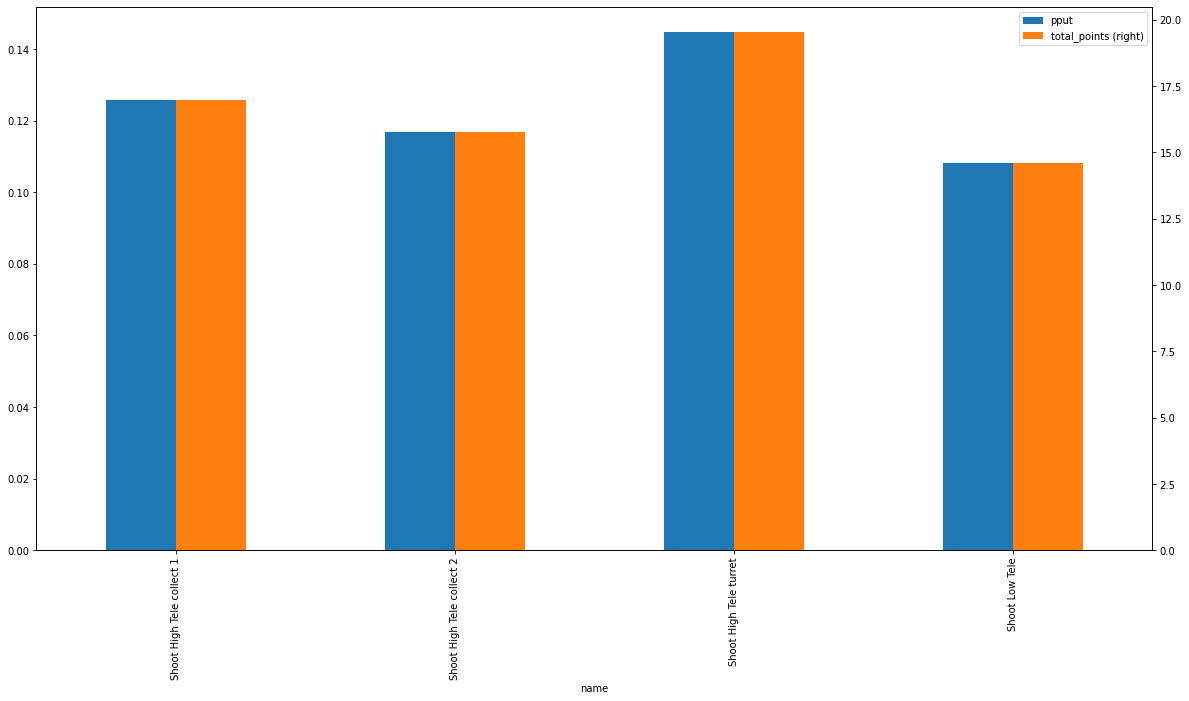

In [ ]:
df.groupby(['name']).mean().plot( y=["pput", "total_points"], secondary_y= 'total_points' , kind="bar",figsize=(20, 10))